In [1]:
!pip install kaggle

In [0]:
from getpass import getpass
import os
user = 'ahmadelsallab'
key = '6b7ffe97ff5bc0656e325b746b72fa31'

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c ashrae-energy-prediction

 81% 72.0M/88.4M [00:00<00:00, 76.7MB/s]
100% 88.4M/88.4M [00:00<00:00, 130MB/s] 
 94% 157M/167M [00:02<00:00, 49.5MB/s]
100% 167M/167M [00:02<00:00, 60.7MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 86.3MB/s]
 99% 118M/120M [00:02<00:00, 41.0MB/s] 
100% 120M/120M [00:02<00:00, 51.8MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 50.4MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 171MB/s]


In [4]:
!unzip -n train.csv.zip
!unzip -n weather_train.csv.zip
!unzip -n building_metadata.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
unzip:  cannot find or open building_metadata.csv.zip, building_metadata.csv.zip.zip or building_metadata.csv.zip.ZIP.


In [0]:
import pandas as pd
train_df = pd.merge(pd.merge(pd.read_csv('train.csv'), pd.read_csv('building_metadata.csv'), on='building_id', how='left'), pd.read_csv('weather_train.csv'), on=['timestamp','site_id'], how='left')



In [0]:
import numpy as np

train_df.meter_reading = train_df.meter_reading.apply(np.log1p)


In [0]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 2622.02 MB
Memory usage after optimization is: 752.28 MB
Decreased by 71.3%


In [0]:
'''Variable Description'''
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [10]:
description(train_df)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float16,0,8494,0,0,0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float16,12127645,116,2008,2004,1991
8,floor_count,float16,16709167,18,NaN,NaN,NaN
9,air_temperature,float16,96658,619,25,25,25


Derived features

In [0]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
train_df["hour"] = train_df["timestamp"].dt.hour
train_df["day"] = train_df["timestamp"].dt.day
train_df["weekday"] = train_df["timestamp"].dt.weekday_name 
train_df["month"] = train_df["timestamp"].dt.month
train_df['year'] = train_df['timestamp'].dt.year

In [12]:
train_df.head()


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,year
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016


Season feature

In [0]:
month_to_season = lambda month:(month%12 + 3)//3

In [14]:
[month_to_season(month) for month in range(1, 13)]

[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

In [0]:
train_df['season'] = train_df.month.apply(month_to_season)


In [0]:
import lightgbm as lgb

https://sefiks.com/2018/10/13/a-gentle-introduction-to-lightgbm-for-applied-machine-learning/


In [0]:
y_train = train_df.meter_reading

In [0]:
#x_train = train_df.drop(columns=['meter_reading'])
features = ['hour','weekday', 'day', 'month', 'season'] # meter must be added, since not all features corr to meter_reading are the same. Same for site_id with less priority
#features = ['meter', 'site_id', 'hour','weekday', 'day', 'month', 'season']
x_train = train_df[features]

Change the following into function:
```
def transform_features(dataset, is_regression=True):
  features = []; categorical_features = []
  num_of_columns = dataset.shape[1]
  
  for i in range(0, num_of_columns):
  column_name = dataset.columns[i]
  column_type = dataset[column_name].dtypes
  
  if i != num_of_columns - 1: #skip target
    features.append(column_name)
  
  if column_type == 'object':
    le.fit(dataset[column_name])
    feature_classes = list(le.classes_)
    encoded_feature = le.transform(dataset[column_name])
    dataset[column_name] = pd.DataFrame(encoded_feature)
  
    if i != num_of_columns - 1: #skip target
    categorical_features.append(column_name)
  
  if is_regression == False and i == num_of_columns - 1:
    num_of_classes = len(feature_classes)
  else:
    num_of_classes = 1
    
  return dataset, features, categorical_features, num_classes
```

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def transform_features(dataset, is_regression=True):
  features = []; categorical_features = []
  num_of_columns = dataset.shape[1]
 
  for i in range(0, num_of_columns):
    column_name = dataset.columns[i]
    column_type = dataset[column_name].dtypes
 
    '''
    if i != num_of_columns - 1: #skip target
      features.append(column_name)
    '''
    features.append(column_name)
    if column_type == 'object':
      le.fit(dataset[column_name])
      feature_classes = list(le.classes_)
      encoded_feature = le.transform(dataset[column_name])
      dataset[column_name] = pd.DataFrame(encoded_feature)
      '''
      if i != num_of_columns - 1: #skip target
        categorical_features.append(column_name)
      '''
      categorical_features.append(column_name)
  if is_regression == False and i == num_of_columns - 1:
    num_of_classes = len(feature_classes)
  else:
    num_of_classes = 1
 
  return dataset, features.copy(), categorical_features.copy(), num_of_classes

In [20]:
'''
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

dataset = x_train
is_regression = True

features = []; categorical_features = []
num_of_columns = dataset.shape[1]
 
for i in range(0, num_of_columns):
 column_name = dataset.columns[i]
 column_type = dataset[column_name].dtypes
 
 if i != num_of_columns - 1: #skip target
  features.append(column_name)
 
 if column_type == 'object':
  le.fit(dataset[column_name])
  feature_classes = list(le.classes_)
  encoded_feature = le.transform(dataset[column_name])
  dataset[column_name] = pd.DataFrame(encoded_feature)
 
  if i != num_of_columns - 1: #skip target
   categorical_features.append(column_name)
 
if is_regression == False and i == num_of_columns - 1:
  num_of_classes = len(feature_classes)
else:
  num_of_classes = 1

'''  

"\nfrom sklearn import preprocessing\nle = preprocessing.LabelEncoder()\n\ndataset = x_train\nis_regression = True\n\nfeatures = []; categorical_features = []\nnum_of_columns = dataset.shape[1]\n \nfor i in range(0, num_of_columns):\n column_name = dataset.columns[i]\n column_type = dataset[column_name].dtypes\n \n if i != num_of_columns - 1: #skip target\n  features.append(column_name)\n \n if column_type == 'object':\n  le.fit(dataset[column_name])\n  feature_classes = list(le.classes_)\n  encoded_feature = le.transform(dataset[column_name])\n  dataset[column_name] = pd.DataFrame(encoded_feature)\n \n  if i != num_of_columns - 1: #skip target\n   categorical_features.append(column_name)\n \nif is_regression == False and i == num_of_columns - 1:\n  num_of_classes = len(feature_classes)\nelse:\n  num_of_classes = 1\n\n"

In [21]:
is_regression = True
x_train, features, categorical_features, num_of_classes = transform_features(x_train, is_regression=is_regression)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
x_train.dtypes # the weekday type becomes int64

hour       int64
weekday    int64
day        int64
month      int64
season     int64
dtype: object

In [23]:
x_train.head()

,hour,weekday,day,month,season
0,0,0,1,1,1
1,0,0,1,1,1
2,0,0,1,1,1
3,0,0,1,1,1
4,0,0,1,1,1


In [24]:
features 

['hour', 'weekday', 'day', 'month', 'season']

In [25]:
categorical_features

['weekday']

train test split

In [0]:
from sklearn.model_selection import KFold, train_test_split
# Make validation set based on train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Actually, all the features are categorical

In [0]:
lgb_train = lgb.Dataset(x_train, y_train
 ,feature_name = features#+categorical_features
 #, categorical_feature = categorical_features
)

In [0]:

params = {
 'task': 'train'
 , 'boosting_type': 'gbdt'
 , 'objective': 'regression' if is_regression == True else 'multiclass'
 , 'num_class': num_of_classes
 , 'metric': 'rmsle' if is_regression == True else 'multi_logloss'
 , 'min_data': 1
 , 'verbose': 1
}
 
gbm = lgb.train(params, lgb_train, num_boost_round=50)

Predict

In [29]:
'''
predictions = gbm.predict(x_train[:100])
target_name = 'meter_reading'
#for index, instance in train_df[:100].iterrows():
for index, instance in y_train[:100].iteritems():
 #actual = instance[target_name]
 actual = instance
 
 if is_regression == True:
  prediction = round(predictions[index])
 else: #classification
  prediction = np.argmax(predictions[index])
 
 print((index+1),' actual= ' ,actual,' prediction= ', prediction)
 '''

"\npredictions = gbm.predict(x_train[:100])\ntarget_name = 'meter_reading'\n#for index, instance in train_df[:100].iterrows():\nfor index, instance in y_train[:100].iteritems():\n #actual = instance[target_name]\n actual = instance\n \n if is_regression == True:\n  prediction = round(predictions[index])\n else: #classification\n  prediction = np.argmax(predictions[index])\n \n print((index+1),' actual= ' ,actual,' prediction= ', prediction)\n "

Visualization

In [30]:
!pip install graphviz

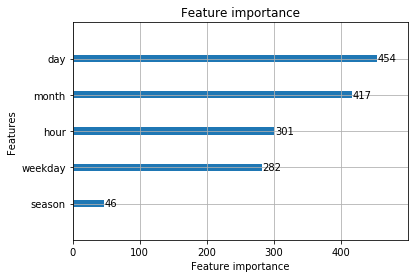

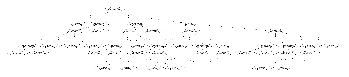

In [31]:
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()
 
ax = lgb.plot_tree(gbm)
plt.show()

Validation MSE

In [32]:

from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse
y_pred  =gbm.predict(x_val)
score = np.sqrt(mse(y_val, y_pred))# we use mse not msle since we already make y_val as np.log1p and so the y_pred
print('Val MSE = ', score)

Val MSE =  2.1333603524631544


Test submission

In [0]:
del train_df
del x_train
del x_val

In [34]:
!unzip -n test.csv.zip
!unzip -n weather_test.csv.zip

# Test prep and features extraction
test_df = pd.merge(pd.merge(pd.read_csv('test.csv'), pd.read_csv('building_metadata.csv'), on='building_id', how='left'), pd.read_csv('weather_test.csv'), on=['timestamp','site_id'], how='left')

test_df = reduce_mem_usage(test_df)

test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
test_df["hour"] = test_df["timestamp"].dt.hour
test_df["day"] = test_df["timestamp"].dt.day
test_df["weekday"] = test_df["timestamp"].dt.weekday_name 
test_df["month"] = test_df["timestamp"].dt.month
test_df['year'] = test_df['timestamp'].dt.year

test_df['season'] = test_df.month.apply(month_to_season)

x_test = test_df[features]
del test_df
x_test, features, categorical_features, num_classes = transform_features(x_test, is_regression=is_regression)

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  weather_test.csv.zip
  inflating: weather_test.csv        
Memory usage of dataframe is 5408.17 MB
Memory usage after optimization is: 1631.16 MB
Decreased by 69.8%


The score predicts to return the abs meter reading, while we predict log(p) + 1.
So we must make exp(pred) - 1.

This is all done using np.expm1 (m1 = minus 1)

In [35]:
!unzip -n sample_submission.csv.zip
sample = pd.read_csv("sample_submission.csv")
sample['meter_reading'] = np.expm1(gbm.predict(x_test))
sample.to_csv('submission.csv', index=False)
sample.head()

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


,row_id,meter_reading
0,0,36.047355
1,1,36.047355
2,2,36.047355
3,3,36.047355
4,4,36.047355


In [36]:
len(sample)

41697600

In [37]:
len(x_test)

41697600